In [2]:
import math
import time
import os

from hermite_functions import hermite_functions
from persim import plot_diagrams
from tqdm import tqdm

import matplotlib.pyplot as plt
import neurokit2 as nk
import scipy.signal
import numpy as np
import persim
import pywt
import mne

import tda_utils
import dataset
import utils

from hermite_functions import hermite_functions
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [3]:
idx = 915
data_dir = "/work/thesathlab/nchsdb/"

pt_ids = []
for pt_file in os.listdir(os.path.join(data_dir, "sleep_data")):
    if pt_file.endswith(".edf"):
        pt_ids.append(pt_file.replace(".edf", ""))

pt_id = pt_ids[idx]
print(pt_id)
save_dir = "/work/thesathlab/manjunath.sh/tmp"
loader = dataset.AirflowSignalProcessor(pt_id=pt_id, data_dir="/work/thesathlab/nchsdb/", save_dir=save_dir)

raw_edf = mne.io.read_raw_edf(loader.edf_fname, verbose=False)
sfreq = raw_edf.info["sfreq"]

target_intervals = loader.find_target_intervals()
airflow_cache = loader.load_epoch_cache(raw_edf, target_intervals)

1423_9898


Loading 1423_9898...: 100%|██████████| 828/828 [00:20<00:00, 40.42it/s]


In [4]:
data = []
dgms_dict = {
    "irr_sublevel": [],
    "airflow_sublevel": [],
    "airflow_rips": [],
}
target_count = 24
count = 0

for idx in tqdm(range(len(airflow_cache)), desc=f"Processing {loader.pt_id}..."):
    if count < target_count:
        count += 1
        continue
    data_arr = airflow_cache.get_epoch_sequence(idx, n_epochs=6)
    sqi = utils.calculate_sqi(data_arr, sfreq)

    # Calculate IRR signal
    irr_signal = loader.calc_irr(data_arr.squeeze(), sampling_freq=sfreq)

    # Sublevel set filtration of IRR signal
    sublevel_dgms_irr = loader.sublevel_set_filtration(irr_signal)

    # Airflow rips filtration
    rips_dgms_airflow = loader.rips_filtration(data_arr, sfreq)

    # Airflow sublevel filtration
    sublevel_dgms_airflow = loader.sublevel_set_filtration(data_arr)

    ps_irr = loader.persistence_summary(sublevel_dgms_irr[0])
    hepc_irr = loader.hepc(sublevel_dgms_irr[0])

    hepc_rips_airflow_0 = loader.hepc(rips_dgms_airflow[0])
    ps_rips_airflow_1 = loader.persistence_summary(rips_dgms_airflow[1])

    hepc_sub_airflow_0 = loader.hepc(sublevel_dgms_airflow[0])
    ps_sub_airflow_0 = loader.persistence_summary(sublevel_dgms_airflow[0])

    # Skipping if we have very few points in filtration
    if np.isnan(sublevel_dgms_irr[0]).sum() > 0:
        continue

    count += 1

    if count >= target_count:
        break

Processing 1423_9898...:   3%|▎         | 24/708 [00:01<00:45, 14.89it/s]


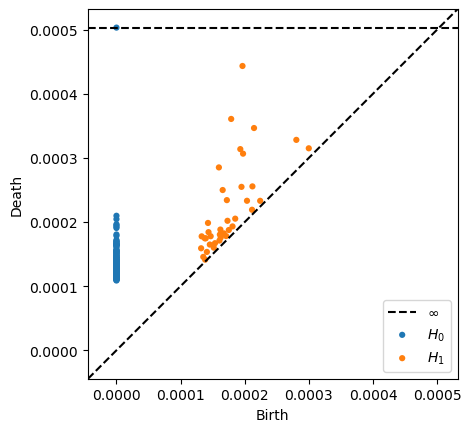

In [5]:
overall_dgms = rips_dgms_airflow
target_dgm = overall_dgms[1]
dgm_clean = target_dgm[~np.isinf(target_dgm).any(1)]

persim.plot_diagrams(overall_dgms)
plt.show()

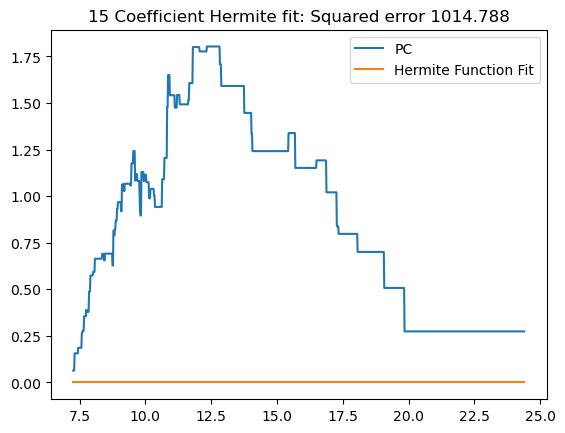

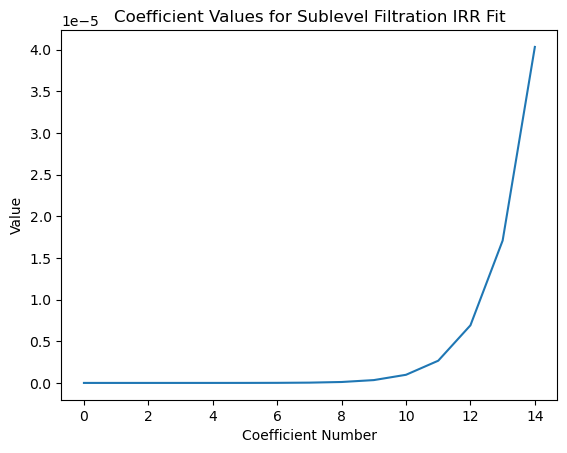

In [6]:
n_coef = 15
# dgm_clean_t = dgm_clean
# dgm_clean_t = dgm_clean - dgm_clean.mean() 
# dgm_clean_t = dgm_clean_t * (5 / np.abs(dgm_clean_t).max())

# dgm_clean_t = (dgm_clean - dgm_clean.mean()) * (5 / np.abs(dgm_clean).max())
# dgm_clean_t = dgm_clean - dgm_clean.mean()
dgm_clean_t = dgm_clean * dataset.hepc_scale["rips_airflow_h1"]
psi_dgms = tda_utils.psi(dgm_clean_t)
x = np.linspace(dgm_clean_t.min(), dgm_clean_t.max(), 1000)
y = np.zeros(x.shape)

for idx, (b, d) in enumerate(dgm_clean_t):
    arr_idx = (x >= b) & (x <= d)
    y[arr_idx] += psi_dgms[idx]
    
coefs = tda_utils.hepc(dgm_clean_t, n_coef=n_coef)

y_pred = np.zeros(y.shape)
for n, coef in enumerate(coefs):
    hn = hermite_functions(n, x, all_n=False)
    y_pred += coef * hn

plt.figure()
plt.plot(x, y, label="PC")
plt.plot(x, y_pred, label="Hermite Function Fit")
plt.legend()


res_h_n = (y_pred - y) ** 2
plt.title(f"{n_coef} Coefficient Hermite fit: Squared error {res_h_n.sum():.3f}")

plt.figure()
plt.plot(coefs)
plt.xlabel("Coefficient Number")
plt.ylabel("Value")
plt.title("Coefficient Values for Sublevel Filtration IRR Fit")

plt.show()

0.00031123396183829755


100%|██████████| 14/14 [00:00<00:00, 7703.04it/s]


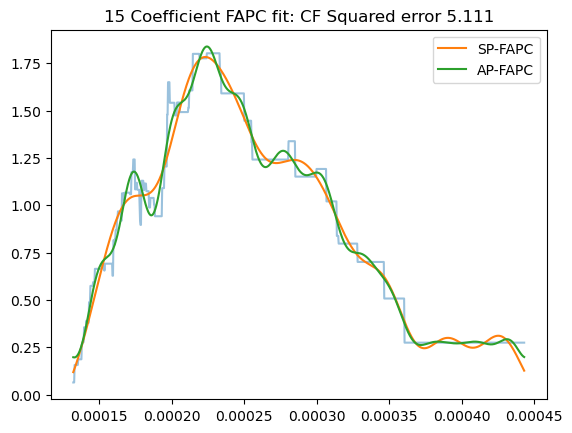

In [8]:
dgm_clean_t = dgm_clean
# dgm_clean_t = dgm_clean * (5 / np.abs(dgm_clean).max())
psi_dgms = tda_utils.psi(dgm_clean_t)
x = np.linspace(dgm_clean_t.min(), dgm_clean_t.max(), 1000) 
y = np.zeros(x.shape)

for idx, (b, d) in enumerate(dgm_clean_t):
    arr_idx = (x >= b) & (x <= d)
    y[arr_idx] += psi_dgms[idx]

coef = np.fft.rfft(y)
coef_app = coef[:n_coef]
approx = np.fft.irfft(coef_app, n=y.shape[0])

# L = dgm_clean_t.max() - dgm_clean_t.min()
key = "rips_airflow_h1"
print(dgm_clean_t.max() - dgm_clean_t.min())
L = dataset.fapc_support[key][1] - dataset.fapc_support[key][0]
b = dgm_clean_t[:, 0]
d = dgm_clean_t[:, 1]
beta = []

beta.append(2 * np.sum(psi_dgms * (d - b)) / L)
for n in tqdm(range(1, n_coef)):
    diff = np.exp(2 * 1.0j * np.pi * b * n / L) - np.exp(2 * 1.0j * np.pi * d * n / L)
    val = diff * 1.0j * L / (2 * np.pi * n)
    beta.append(2 * np.sum(psi_dgms * val) / L)

beta = np.asarray(beta)
approx_fft = np.fft.irfft(coef_app, n=y.shape[0])

approx_cf = np.zeros(x.shape)
for n, beta_n in enumerate(beta):
    # approx_cf += beta_n * np.exp(2 * 1.0j * np.pi * n * x / L) 
    if n == 0:
        approx_cf += np.real(beta_n) / 2
    else:
        approx_cf += np.real(beta_n) * np.cos(2 * np.pi * n * x / L) + np.imag(beta_n) * np.sin(2 * np.pi * n * x / L)

res_fft = (approx_fft - y) ** 2
res_cf = (approx_cf - y) ** 2

plt.figure()
plt.plot(x, y, alpha=0.45)
plt.plot(x, approx_cf, label="SP-FAPC")
plt.plot(x, approx_fft, label="AP-FAPC")
plt.legend()
plt.title(f"{n_coef} Coefficient FAPC fit: CF Squared error {res_cf.sum():.3f}")
plt.show()

In [78]:
(-5e-4) + 1e-3

0.0005

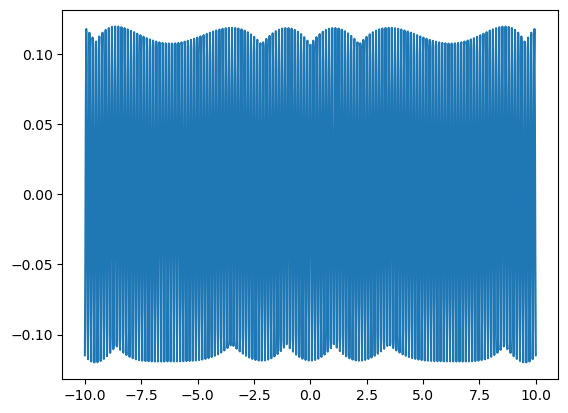

In [195]:
xarr = np.linspace(-10, 10, 1000)
harr = hermite_functions(1024, xarr, all_n=False)

plt.figure()
plt.plot(xarr, harr)
plt.show()